In [18]:
!pip install scikit-survival

In [19]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

from scipy.stats import gaussian_kde, binomtest

from sksurv.datasets import load_gbsg2, load_whas500, load_aids
from sksurv.datasets import get_x_y
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder
from sksurv.metrics import concordance_index_censored, cumulative_dynamic_auc
from sksurv.nonparametric import kaplan_meier_estimator

from scipy.stats import mannwhitneyu, pearsonr
from sklearn.utils import resample
from patsy import dmatrix

import shap


In [20]:
# Split the dataset and fit the naive model and the recommender.
def split_and_train(X, y, model_name, seed=20):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

    model = get_model(model_name, seed)
    model.fit(X_train, y_train)

    return model, (X_train, y_train), (X_test, y_test)

def get_model(name, seed=20):
  if name == 'rf':
    model = RandomSurvivalForest(n_estimators=500, min_samples_split=10, min_samples_leaf=15, n_jobs=-1, random_state=seed)
  elif name == 'cox':
    model = CoxPHSurvivalAnalysis()
  else:
    raise ValueError(f"Unrecognised model name '{name}'!")

  return model

# SHAP Analysis


In [21]:
## Generate shap analysis results and shap plots for the Recommendar
def _extract_time_event(y):
        """
        Return (time, event) as 1D numpy arrays.

        Supports:
          * sksurv structured arrays from load_gbsg2, load_whas500, load_aids, ...
          * pandas DataFrame with usual column names.
        """

        # Case 1: structured array (what sksurv datasets return)
        if isinstance(y, np.ndarray) and y.dtype.names is not None:
            names = list(y.dtype.names)
            if len(names) != 2:
                raise ValueError(
                    f"Structured array y must have exactly 2 fields, got {names}"
                )

            # By sksurv convention: first field = event indicator (bool),
            # second field = time (float). :contentReference[oaicite:1]{index=1}
            event = y[names[0]].astype(bool)
            time = y[names[1]].astype(float)
            return time, event

        # Case 2: pandas DataFrame
        if isinstance(y, pd.DataFrame):
            # possible event column names across datasets
            event_candidates = [
                "event", "Status", "status", "death", "fstat",
                "cens", "censor", "censor_d"
            ]
            time_candidates = [
                "time", "Survival_in_days", "lenfol", "time_d", "futime"
            ]

            event_col = next((c for c in event_candidates if c in y.columns), None)
            time_col = next((c for c in time_candidates if c in y.columns), None)

            if event_col is None or time_col is None:
                raise ValueError(
                    "Could not infer event/time columns in DataFrame y; "
                    "got columns: " + ", ".join(y.columns)
                )

            event = y[event_col].astype(bool).to_numpy()
            time = y[time_col].astype(float).to_numpy()
            return time, event

        raise TypeError(
            "Unsupported type for y. Use a sksurv structured array or a pandas DataFrame."
        )

def get_explanations(model, X_test, y_test, eps, risk_level='low'):
    names = list(y_test.dtype.names)
    if risk_level == 'high':
        risk_data = X_test[y_test[names[0]] == 1]
    elif risk_level == 'low':
        risk_data = X_test[y_test[names[0]] == 0]
    else:
        risk_data = X_test

    # compute the reference point (average patient)
    X_mean = risk_data.mean().to_frame().T
    # find average risk
    y_mean = model.predict(X_mean)

    if (risk_level == 'high') | (risk_level == 'low'):
      y_std = np.std(model.predict(risk_data))
      # predict risk for all
      y_pred = model.predict(X_test)

      eps = y_std * eps


      # select only those individuals whose change in risk with respect to the reference point is smaller than epsilon (i.e. close to 0)
      sel_mask = np.abs(y_pred - y_mean) < eps

      # use the reference point

      sel_data = X_test[sel_mask]
    else:
      sel_data = X_test

    ex = shap.KernelExplainer(model.predict, X_mean)
    explanation = ex(sel_data)
    df_shap = pd.DataFrame(explanation.values, columns=X_test.columns)

    # get SHAP values of the selected individuals (delta_R close to 0)
    return df_shap, sel_data

def make_plot(df_shap, org_df, filename, plot_type='scatter', xlabel='SHAP value', figsize=(4, 3)):
  features = df_shap.columns.to_list()
  n_feats = len(features)

  fig, ax = plt.subplots(figsize=figsize)

  if plot_type == 'violin':
    if org_df is not None:
      shap_long = df_shap.melt(var_name='Feature', value_name='SHAP Value')
      feat_long = org_df.melt(var_name='Feature', value_name='Feature Value')
      data = pd.concat([shap_long, feat_long['Feature Value']], axis=1)
    else:
      raise ValueError('No original faeture values provided')

    for i, feature in enumerate(features):
      df_feat = data[data['Feature'] == feature]
      try:
        kde = gaussian_kde(df_feat['SHAP Value'].values)
        x_vals = df_feat['SHAP Value'].values
        density_vals = kde(x_vals)

        density_vals = density_vals/density_vals.max()*0.4

        y_center = i
        y_vals = np.random.uniform(low=i-density_vals, high=i+density_vals)
      except np.linalg.LinAlgError:
        print(f'KDE failed for feature {feature}, using scatter fallback')
        x_vals = df_feat['SHAP Value'].values
        y_vals = np.full_like(df_feat['SHAP Value'], fill_value=i, dtype=float)
      val = df_feat['Feature Value'].values
      if (val.max() - val.min()) == 0.0:
        val_norm = np.full_like(val, fill_value=val.max(), dtype=float)
      else:
        val_norm = (val - val.min()) / (val.max() - val.min())

      sc = ax.scatter(
          x_vals, y_vals,
          c=val_norm,
          cmap='coolwarm', edgecolors='None', s=20, alpha=0.8
      )

    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('Feature Value')
    cbar.set_ticks([])
    cbar.ax.text(1.05, 0.05, 'Low', transform=cbar.ax.transAxes, va='center')
    cbar.ax.text(1.05, 0.95, 'High', transform=cbar.ax.transAxes, va='center')
  elif plot_type == 'bar':
    for i, feature in enumerate(features):
      x = df_shap[feature].values
      y = np.full_like(x, fill_value=i, dtype=float)
      plt.barh(y, x, align='center')

  ax.axvline(0.0, c='k', linewidth=0.5)
  ax.set_yticks(np.arange(n_feats))
  ax.set_yticklabels(features)

  ax.set_xlabel(xlabel)
  ax.set_ylabel('Feature')
  ax.spines['top'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['right'].set_visible(False)

  plt.grid(True, axis='both', linestyle='--', alpha=0.5)
  plt.savefig(f'plots/{filename}.png', dpi=1000)
  plt.tight_layout()
  plt.show()

# Generate Recommendations

In [22]:
class ShapleyAnalysis:
  # Tools used for generating recommendations
  def __init__(self, var_threshold, prop_thresh, pval_thresh, random_state):
    self.var_thresh = var_threshold
    self.prop_thresh = prop_thresh
    self.pval_thresh = pval_thresh
    self.random_state = random_state

  def inclu_exclu_var(self, df):
    """
      Generate recommendations for feature exclusion
      Args:
        shap_file: shap analysis values
        sel_data: feature values

      Returns:
        The features that are non-linearly correlated with the outcome
    """
    eps = np.std(df.abs().to_numpy(dtype=float), ddof=1)
    for col in df.columns:
      vals = df[col].values
      ci_lo, ci_hi = self.bootstrap_analysis(vals, stats_type='mean_abs')
      decision = (ci_lo >= -self.var_thresh*eps) and (ci_hi <= self.var_thresh*eps)
      if decision:
        print(col)

  def non_linear_test(self, shap_file, sel_data):
    """
      Generate recommendations for non-linearity

      Args:
        shap_file: shap analysis values
        sel_data: feature values

      Returns:
        The features that are non-linearly correlated with the outcome
    """
    for c in shap_file.columns:
      corr = pearsonr(shap_file[c].to_numpy(), sel_data[c].to_numpy())
      if np.abs(corr[0]) < 0.1:
        print(f'{c}: {corr[0]:.2f} ({corr[1]:.2f})')

  def wilcoxon_rank_sum_test(self, df1, df2):
    """
      Genrate recommendations for feature interactions

      Args:
        df1, df2: shap analysis files for two populations after stratification.

      Returns:
        The features that are interacted with the stratified feature
    """
    for col in df1.columns:
        val1 = df1[col].to_numpy()
        val2 = df2[col].to_numpy()

        if len(val1) == 0 or len(val2) == 0:
            continue
        stat, p = mannwhitneyu(val1, val2, method='asymptotic', alternative='two-sided')
        if p <= self.pval_thresh:
            print(col)

  def bootstrap_analysis(self, x, b=1000, alpha=0.05, stats_type='median_abs'):
    """
      Bootstrap analysis for performance

      Args:
        x: dataset that will be evaluated using bootstrap analysis.
        b: bootstrap iterations
        alpha: confidence level

      Returns:
        low and high confidence intervals
    """
    rng = np.random.default_rng(self.random_state)
    # x = x.to_numpy()
    n = x.size
    boot = []
    for _ in range(b):
        xb = resample(
            x,
            replace=True,
            n_samples=n,
            random_state=int(rng.integers(1_000_000_000)),
        )
        boot.append(self.get_data_stats(xb, stats_type))
    lo, hi = np.percentile(boot, [100 * alpha / 2, 100 * (1 - alpha / 2)])

    return lo, hi


  @staticmethod
  def get_data_stats(x, stats_type='mean_abs'):
      if stats_type == 'mean_abs':
          data = np.mean(np.abs(x), axis=0)
      elif stats_type == 'median_abs':
          data = np.median(np.abs(x), axis=0)
      elif stats_type == 'mean':
          data = np.mean(x, axis=0)
      elif stats_type == 'median':
          data = np.median(x, axis=0)
      else:
          raise ValueError('Unknown stats')
      return data


## Strata analysis

In [23]:
def sign_balance_test(df):
  # Generate strata
  result = []
  for col in df.columns:
    vals = df[col].values

    n = len(vals[vals != 0])
    if n < 0.1 * len(vals):
      continue
    n_pos = (vals > 0).sum()
    test = binomtest(n_pos, n, 0.5)
    balanced = (test.pvalue > 0.05)
    if balanced:
      print(col)

In [24]:
def strata_generate(data, variable, X_test, y_test, thresh):
  # Split datasets into two stratas
  mask1 = (data[variable] < thresh)
  mask2 = (data[variable] > thresh)
  X_test_group1 = X_test[mask1]
  X_test_group2 = X_test[mask2]
  y_test_group1 = y_test
  y_test_group2 = y_test
  X_test_list = [X_test_group1, X_test_group2]
  y_test_list = [y_test_group1, y_test_group2]

  return X_test_list, y_test_list


In [25]:
def stratify_shap_analysis(model, X_test_list, y_test_list, variable, risk_level):
    num_group = len(X_test_list)
    strata_shap = []
    for i in range(num_group):
        X_test = X_test_list[i]
        y_test = y_test_list[i]
        shap_file, sel_data = get_explanations(model, X_test, y_test, eps=0.05, risk_level=risk_level)
        # make_plot(shap_file, sel_data, f'aids_shap_{i}_low', plot_type='violin', xlabel='SHAP value', figsize=(8, 6))
        strata_shap.append(shap_file)
    return strata_shap

In [26]:
## Generate interactions
## run sign_balance_test to find variables to be stratified
## strata_generate(data, variable, X_test, y_test, thresh) to generate the stratified dataset
## Then run stratify_shap_analysis to generate stratified shapley analysis
## Then run shapAna = ShapleyAnalysis(0.05, 0.05, 0.05, random_state=1)
## Finally run shapAna.wilcoxcon_rank_sum_test(data1, data2) to get interactions



# Integrate recommendations

In [27]:
## Integrate feature exclusion recommendations on the dataset
def exclusion_analysis(data, exclu_feature):
  data = data.drop(columns=exclu_feature, errors='ignore')
  return data


In [28]:
## Integrate non-linearity recommendations on the dataset
def nonlinear_analysis(data, nonlinear_feature, nonlinear_type='quadratic'):
    data_cols = data.columns
    nonlinear_cols = []
    for feature in nonlinear_feature:
        if feature in data_cols:
            name = f'{feature}_{nonlinear_type}'
            if nonlinear_type == 'quadratic':
                data[feature] = data[feature] - data[feature].mean()
                quad = (data[feature]**2).rename(name)
                nonlinear_cols.append(quad.to_frame())
            else:
                basis = dmatrix(f"0+cr({feature}, df=3)", data,
                                return_type="dataframe",
                                NA_action='raise')
                basis = basis.add_prefix(name)
                basis = basis.reindex(data.index)
                nonlinear_cols.append(basis)
    if nonlinear_cols:
        nonlinear = pd.concat(nonlinear_cols, axis=1)
        nonlinear_data = pd.concat([data, nonlinear], axis=1)
    else:
        nonlinear_data = data.copy()

    return nonlinear_data

In [29]:
## Integrate interaction recommendations on the dataset
def interaction_analysis(data, inter_feat, interact_list, nonlinear_list):
    data_cols = data.columns
    inter_cols = {}
    for item in interact_list:
        a = inter_feat
        b = item
        if a in data_cols:
            if b in data_cols:
                name = f'{a}_x_{b}'
                inter_cols[name] = data[a] * data[b]
            if a in nonlinear_list:
                if b in nonlinear_list:
                    name = f'{a}_quad_x_{b}_quad'
                    inter_cols[name] = data[a + '_quadratic'] * data[b + '_quadratic']
                else:
                    name = f'{a}_quad_x_{b}'
                    inter_cols[name] = data[a + '_quadratic'] * data[b]
            else:
                if b in nonlinear_list:
                    name = f'{a}_x_{b}_quad'
                    inter_cols[name] = data[a] * data[b + '_quadratic']

    inter = pd.DataFrame(inter_cols, index=data.index) if inter_cols else pd.DataFrame(index=data.index)
    interact_data = pd.concat([data, inter], axis=1)

    return interact_data

# Calibration



## Generate calibration plots

In [30]:
class CalibrationPerform:
  def __init__(self, t0, n_bins=5, kind='survival', n_boot=0,
                random_state=0, save_folder=None, model_name=['RandomForest']):
      self.t0 = t0
      self.n_bins = n_bins
      self.kind = kind
      self.n_boot = n_boot
      self.random_state = random_state
      self.save_folder = save_folder
      self.model_name = model_name

  def _extract_time_event(self, y):
        """
        Return (time, event) as 1D numpy arrays.

        Supports:
          * sksurv structured arrays from load_gbsg2, load_whas500, load_aids, ...
          * pandas DataFrame with usual column names.
        """

        # Case 1: structured array (what sksurv datasets return)
        if isinstance(y, np.ndarray) and y.dtype.names is not None:
            names = list(y.dtype.names)
            if len(names) != 2:
                raise ValueError(
                    f"Structured array y must have exactly 2 fields, got {names}"
                )

            # By sksurv convention: first field = event indicator (bool),
            # second field = time (float). :contentReference[oaicite:1]{index=1}
            event = y[names[0]].astype(bool)
            time = y[names[1]].astype(float)
            return time, event

        # Case 2: pandas DataFrame
        if isinstance(y, pd.DataFrame):
            # possible event column names across datasets
            event_candidates = [
                "event", "Status", "status", "death", "fstat",
                "cens", "censor", "censor_d"
            ]
            time_candidates = [
                "time", "Survival_in_days", "lenfol", "time_d", "futime"
            ]

            event_col = next((c for c in event_candidates if c in y.columns), None)
            time_col = next((c for c in time_candidates if c in y.columns), None)

            if event_col is None or time_col is None:
                raise ValueError(
                    "Could not infer event/time columns in DataFrame y; "
                    "got columns: " + ", ".join(y.columns)
                )

            event = y[event_col].astype(bool).to_numpy()
            time = y[time_col].astype(float).to_numpy()
            return time, event

        raise TypeError(
            "Unsupported type for y. Use a sksurv structured array or a pandas DataFrame."
        )

  def plot_survival_calibration(self, X, y, model):
    rng = np.random.default_rng(self.random_state)
    est = self.extract_survival_estimator(model)

    surv_funcs = est.predict_survival_function(X, return_array=False)
    pred_surv_t0 = np.array([float(sf(self.t0)) for sf in surv_funcs])

    if self.kind == 'survival':
        pred_cal = pred_surv_t0
    elif self.kind == 'risk':
        pred_cal = 1.0 - pred_surv_t0
    else:
        raise ValueError("kind must be 'survival' or 'risk'")

    edges = self.quantile_bins(pred_cal)
    bin_idx = np.digitize(pred_cal, edges[1:-1], right=True)
    n_bins_eff = edges.size - 1

    time, event = self._extract_time_event(y)

    bin_pred, bin_obs, bin_counts = [], [], []
    obs_ci_lo, obs_ci_hi = [], []
    MIN_N = 10

    for b in range(n_bins_eff):
        mask = bin_idx == b
        if mask.sum() < MIN_N:
            continue

        # compute KM *first*
        s_hat = self.km_s_at(time[mask], event[mask])
        if np.isnan(s_hat):
            # if KM at t0 is undefined in this bin, skip the bin entirely
            continue

        # only now append pred & obs so lengths always match
        bin_pred.append(pred_cal[mask].mean())

        obs_val = s_hat if self.kind == 'survival' else (1.0 - s_hat)
        bin_obs.append(obs_val)
        bin_counts.append(mask.sum())

        if self.n_boot > 0:
            boot_vals = []
            for _ in range(self.n_boot):
                idx = rng.integers(0, mask.sum(), mask.sum())
                t_b = time[mask][idx]
                e_b = event[mask][idx]
                s_b = self.km_s_at(t_b, e_b)
                if np.isnan(s_b):
                    # extremely unlikely if original s_hat wasn't NaN,
                    # but be safe and skip this resample
                    continue
                boot_vals.append(
                    s_b if self.kind == 'survival' else (1.0 - s_b)
                )
            if len(boot_vals) > 0:
                lo, hi = np.percentile(boot_vals, [2.5, 97.5])
                obs_ci_lo.append(lo)
                obs_ci_hi.append(hi)

    bin_pred = np.asarray(bin_pred)
    bin_obs = np.asarray(bin_obs)
    bin_counts = np.asarray(bin_counts)
    bin_obs_ci = (
        (np.asarray(obs_ci_lo), np.asarray(obs_ci_hi))
        if self.n_boot > 0 and len(obs_ci_lo) > 0
        else None
    )

    return {
        "bin_pred": bin_pred,
        "bin_obs": bin_obs,
        "bin_counts": bin_counts,
        "bin_obs_ci": bin_obs_ci,
        "edges": edges,
        "t0": self.t0,
        "kind": self.kind,
    }

  def calib_estimate(self, model, X, y):
      est_res = self.plot_survival_calibration(X=X, y=y, model=model)
      bin_pred, bin_obs, bin_n = est_res['bin_pred'], est_res['bin_obs'], est_res['bin_counts']

      # coef = np.polyfit(bin_pred, bin_obs, 1)
      # slope_ols, intercept_ols = coef[0], coef[1]
      w = np.asarray(bin_n) if bin_n is not None else np.ones_like(bin_pred)
      X = np.c_[np.ones_like(bin_pred), bin_pred]

      # W = np.diag(w)
      beta = np.linalg.inv(X.T @ (w[:, None] * X)) @ (X.T @ (w * bin_obs))
      intercept, slope = beta[0], beta[1]

      print(f'The intercept is {intercept}')
      print(f'The slope is {slope}')

  def calib_plot(self, model_lst, data_lst, ax=None, title=None):
      ### Generate calibration plots
      if ax is None:
          fig, ax = plt.subplots(figsize=(5, 5))
      for i, mdl in enumerate(model_lst):
          X_i, y_i = data_lst[i][0], data_lst[i][1]
          est_res = self.plot_survival_calibration(X=X_i, y=y_i, model=mdl)
          bin_pred, bin_obs, bin_obs_ci = est_res['bin_pred'], est_res['bin_obs'], est_res['bin_obs_ci']
          ax.plot(bin_pred, bin_obs, marker='o', linestyle='-',
                  label=f'Observed (KM)_{self.model_name[i]}')

          if self.kind == 'survival':
              y_label = 'Observed survival'
              x_label = 'Predicted survival'
          elif self.kind == 'risk':
              y_label = 'Observed risk'
              x_label = 'Predicted risk'
          else:
              raise ValueError('Kind must be "survival" or "risk".')

          minv = min(0.0, bin_pred.min(), bin_obs.min())
          maxv = max(1.0, bin_pred.max(), bin_obs.max())
          ax.plot([minv, maxv], [minv, maxv],
                  color='black', linestyle='--', linewidth=1.2,
                  label='Perfect calibration')
          ax.set_xlim(minv, maxv)
          ax.set_ylim(minv, maxv)
          # ax.set_xlim(0.5, 1.0)
          # ax.set_ylim(0.5, 1.0)
          ax.set_xlabel(x_label)
          ax.set_ylabel(y_label)
          if title is None:
              title = f'Calibration plot ({self.kind})'
          ax.set_title(title)
          ax.grid(True, linestyle='--', alpha=0.4)
          ax.legend()

          if bin_obs_ci is not None:
              lo, hi = bin_obs_ci
              ax.vlines(bin_pred, lo, hi, alpha=0.6)
              # ax.set_xlim(0.5, 1.0)
              # ax.set_ylim(0.5, 1.0)
          plt.savefig(
              os.path.join(self.save_folder,
                          f'Calibration_plot_{self.model_name}.pdf'),
              dpi=1000,
              bbox_inches='tight'
          )

  def quantile_bins(self, x):
      qs = np.linspace(0, 1, self.n_bins + 1)
      edges = np.quantile(x, qs)
      edges = np.unique(edges)

      if edges.size < 2:
          edges = np.array([x.min(), x.max()])
      return edges

  def km_s_at(self, time, event):
    # Generate Kaplan–Meier estimator
    if time.size == 0:
        return np.nan
    t, s = kaplan_meier_estimator(event, time)
    if self.t0 <= t.min():
        return 1.0
    if self.t0 > t.max():
        return np.nan
    eps = 1e-12
    return float(np.interp(self.t0 - eps, t, s))

  @staticmethod
  def extract_survival_estimator(model):
      if hasattr(model, "predict_survival_function"):
          return model
      if hasattr(model, "named_steps"):
          for _, step in model.named_steps.items():
              if hasattr(step, "predict_survival_function"):
                  return step
      raise AttributeError(
          "Could not find an estimator with predict_survival_function in `model`."
      )

In [31]:
def cox_risk_score(model, x):
    if hasattr(model, 'decision_function'):
        return model.decision_function(x)
    if hasattr(model, 'predict'):
        return model.predict(x)
    if hasattr(model, 'predict_partial_hazard'):
        return model.predict_partial_hazard(x).ravel()
    raise AttributeError('Cox model has no usable scoring method')

In [32]:
class MetricEval:
    def __init__(self, num_of_b, seed=1):
        self.num_of_b = num_of_b
        self.seed = seed
        self.rng = np.random.default_rng(self.seed)

    def boot_cindex_diff(self, y_test, s1, s2):
        ### Generate bootstrap performance difference between two models
        event = y_test['event'].astype(bool)
        time = y_test['time'].astype(float)
        n = len(time)

        d_obs = self.cindex(event, time, s2) - self.cindex(event, time, s1)

        diffs = np.empty(self.num_of_b)
        for b in range(self.num_of_b):
            idx = self.rng.integers(0, n, size=n)
            diffs[b] = self.cindex(event[idx], time[idx], s2[idx]) - \
                       self.cindex(event[idx], time[idx], s1[idx])

        lo, hi = np.percentile(diffs, [2.5, 97.5])
        upper_tail = np.mean(diffs >= 0)
        lower_tail = np.mean(diffs <= 0)
        p_two = 2 * min(upper_tail, lower_tail)
        p_two = min(1.0, p_two)

        return d_obs, (lo, hi), p_two

    def boot_matric(self, y_test, s, metric_type):
        ### Generate bootstrap performance
        boot_vals = np.empty(self.num_of_b)
        if metric_type == 'c-index':
            event = y_test['event'].astype(bool)
            time = y_test['time'].astype(float)
            n = len(time)
            print(n)
            val_obs = self.cindex(event, time, s)

            for b in range(self.num_of_b):
                idx = self.rng.integers(0, n, size=n)
                if metric_type == 'c-index':
                    boot_vals[b] = self.cindex(event[idx], time[idx], s[idx])
            lo, hi = np.percentile(boot_vals, [2.5, 97.5])
            upper_tail = np.mean(boot_vals >= val_obs)
            lower_tail = np.mean(boot_vals <= val_obs)
            p_two = 2 * min(upper_tail, lower_tail)
            p_two = min(1.0, p_two)

        return val_obs, (lo, hi), p_two

    def cal_metric_CI(self, model, data, data_y, metric):
        # Calculate confidence intervials for the metric
        boot_vals = np.empty(self.num_of_b)
        if metric == 'c-index':
                # Make sure shapes are consistent
            n = data.shape[0]

            # If X / y are pandas, use .iloc
            if hasattr(data, "iloc"):
                get_X = lambda idx: data.iloc[idx]
            else:
                get_X = lambda idx: data[idx]

            if hasattr(y, "iloc"):
                get_y = lambda idx: data_y.iloc[idx]
            else:
                get_y = lambda idx: data_y[idx]

            val_obs = model.score(data, data_y)

            boot_vals = np.empty(self.num_of_b)
            for b in range(self.num_of_b):
                idx = self.rng.integers(0, n, size=n)
                X_b = get_X(idx)
                y_b = get_y(idx)
                if metric == 'c-index':
                    boot_vals[b] = model.score(data, data_y)
            lo, hi = np.percentile(boot_vals, [2.5, 97.5])
            upper_tail = np.mean(boot_vals >= val_obs)
            lower_tail = np.mean(boot_vals <= val_obs)
            p_two = 2 * min(upper_tail, lower_tail)
            p_two = min(1.0, p_two)
        print(f'{metric} = {val_obs:.3f} (95% CI {lo:.3f}-{hi:.3f}), p = {p_two:.4f}')

    @staticmethod
    def cindex(event, time, s):
        c, *_ = concordance_index_censored(event, time, s)
        return c

# GBSG 2

## Generate Baseline and the Recommendar

In [33]:
## Load the dataset and train the naive model and the recommendar.
X, y = load_gbsg2()

grade_str = X.loc[:, "tgrade"].astype(object).values[:, np.newaxis]
grade_num = OrdinalEncoder(categories=[["I", "II", "III"]]).fit_transform(grade_str)

X_no_grade = X.drop("tgrade", axis=1)
Xt = OneHotEncoder().fit_transform(X_no_grade)
Xt.loc[:, "tgrade"] = grade_num
con_cols = ['age', 'estrec', 'progrec', 'tsize']
Xt[con_cols] = StandardScaler().fit_transform(Xt[con_cols])

Xt.rename(columns={'horTh=yes': 'horTh', 'menostat=Post': 'menostat'}, inplace=True)

ex_model, (X_train, y_train), (X_test, y_test) = split_and_train(Xt, y, 'rf')
org_model, (X_train, y_train), (X_test, y_test) = split_and_train(Xt, y, 'cox')


The intercept is 0.1064496020215765
The slope is 0.963234214448954
The intercept is -0.0037661120132654077
The slope is 1.163133198257668


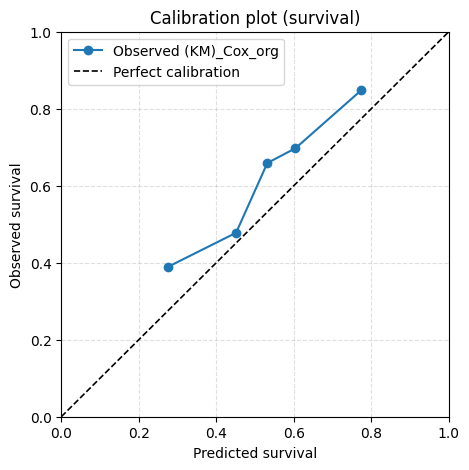

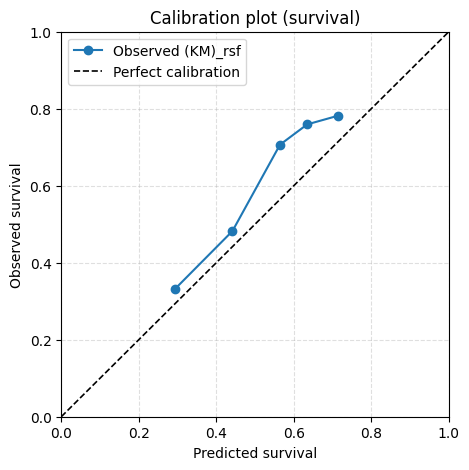

In [34]:
## Evaluate original model
evaluator = MetricEval(1000)
# evaluator.cal_metric_CI(org_model, X_test, y_test,'c-index')
calib = CalibrationPerform(t0=1500, n_bins=5, kind='survival', random_state=0, save_folder='plots/', model_name=['Cox_org'])
calib.calib_plot([org_model], [[X_test, y_test]])
calib.calib_estimate(org_model, X_test, y_test)

## Evaluate rsf model
evaluator = MetricEval(1000)
# evaluator.cal_metric_CI(ex_model, X_test, y_test,'c-index')
calib = CalibrationPerform(t0=1500, n_bins=5, kind='survival', random_state=0, save_folder='plots/', model_name=['rsf'])
calib.calib_plot([ex_model], [[X_test, y_test]])
calib.calib_estimate(ex_model, X_test, y_test)

## Generate recommendations

  0%|          | 0/77 [00:00<?, ?it/s]

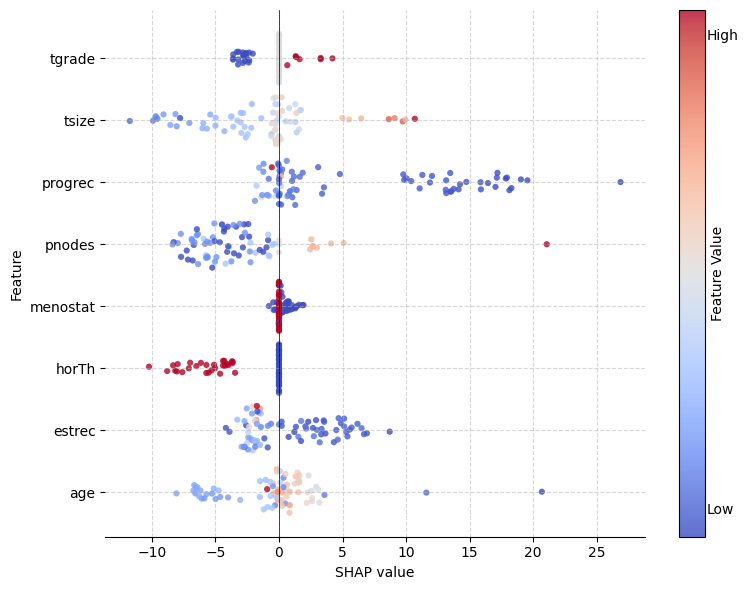

  0%|          | 0/74 [00:00<?, ?it/s]

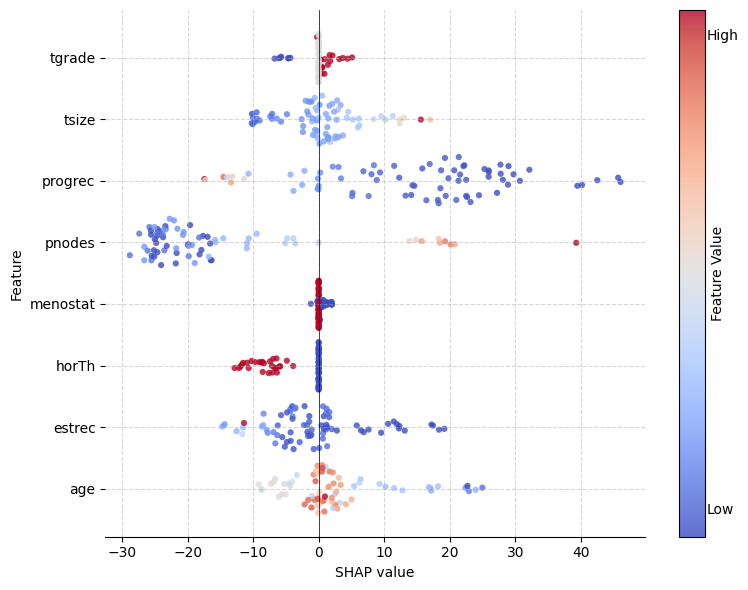

In [35]:
## Get feature attribution
org_X = X_train.copy()
org_y = y_train.copy()
df_shap_low, sel_data_low = get_explanations(ex_model, org_X, org_y, eps=0.2, risk_level='low')
make_plot(df_shap_low, sel_data_low, 'GBSG2_org_shap_low', plot_type='violin', xlabel='SHAP value', figsize=(8, 6))
df_shap_high, sel_data_high = get_explanations(ex_model, org_X, org_y, eps=0.2, risk_level='high')
make_plot(df_shap_high, sel_data_high, 'GBSG2_org_shap_high', plot_type='violin', xlabel='SHAP value', figsize=(8, 6))

In [36]:
shapana = ShapleyAnalysis(0.05, 0.05, 0.05, random_state=20)
shapana.inclu_exclu_var(df_shap_low)
shapana.inclu_exclu_var(df_shap_high)
print('======non-linear======')
shapana.non_linear_test(df_shap_low, sel_data_low)
shapana.non_linear_test(df_shap_high, sel_data_high)

======non-linear======


In [37]:
print('====== Low risk cohort ======')
sign_balance_test(df_shap_low)
print('====== High risk cohort ======')
sign_balance_test(df_shap_high)

====== Low risk cohort ======
age
estrec
====== High risk cohort ======
age
estrec
tsize
tgrade


In [38]:
strata = {'age':0, 'estrec':0, 'progrec':6, 'horTh':-2}
# strata = {'pnodes':-1, 'tsize':0}
for variable, thresh in strata.items():
  print(f'The stratified variable is {variable}')
  X_test_list, y_test_list =strata_generate(df_shap_low, variable, sel_data_low.reset_index(drop=True), y_test, thresh)
  shap_file = stratify_shap_analysis(ex_model, X_test_list, y_test_list, variable, risk_level=None)
  df1, df2 = shap_file[0], shap_file[1]
  shapana.wilcoxon_rank_sum_test(df1, df2)





The stratified variable is age


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

tsize
The stratified variable is estrec


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

estrec
pnodes
The stratified variable is progrec


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

age
estrec
horTh
menostat
pnodes
tgrade
The stratified variable is horTh


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

estrec
menostat
pnodes
progrec
tsize
tgrade


In [39]:
strata = {'age':0, 'tsize':0, 'tgrade':0, 'horTh':-1, 'estrec':0, 'progrec':20}

for variable, thresh in strata.items():
  print(f'The stratified variable is {variable}')
  X_test_list, y_test_list =strata_generate(df_shap_high, variable, sel_data_high.reset_index(drop=True), y_test, thresh)
  shap_file = stratify_shap_analysis(ex_model, X_test_list, y_test_list, variable, risk_level=None)
  df1, df2 = shap_file[0], shap_file[1]
  shapana.wilcoxon_rank_sum_test(df1, df2)

The stratified variable is age


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

age
tsize
The stratified variable is tsize


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

tsize
The stratified variable is tgrade


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

The stratified variable is horTh


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

age
menostat
The stratified variable is estrec


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

estrec
pnodes
tsize
The stratified variable is progrec


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

age
pnodes


## Integrate recommendations

c-index = 0.674 (95% CI 0.674-0.674), p = 1.0000
The intercept is 0.0838428953760864
The slope is 1.0184135143918016


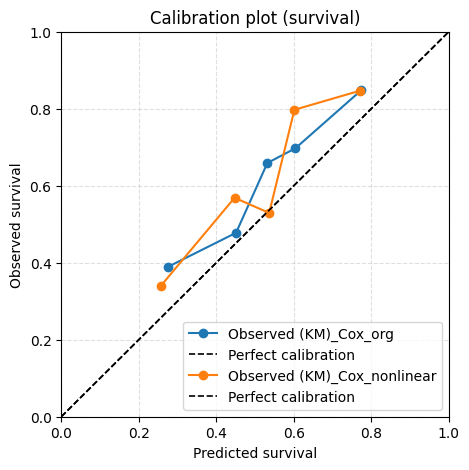

In [40]:
nonlinear_feature = ['age']
nonlinear_train = X_train.copy()
nonlinear_test = X_test.copy()
X_train_nonlinear = nonlinear_analysis(nonlinear_train, nonlinear_feature, nonlinear_type='quadratic')
X_test_nonlinear = nonlinear_analysis(nonlinear_test, nonlinear_feature, nonlinear_type='quadratic')
cox_new_model = get_model('cox', 20)
cox_new_model.fit(X_train_nonlinear, y_train)

evaluator.cal_metric_CI(cox_new_model, X_test_nonlinear, y_test,'c-index')
calib = CalibrationPerform(t0=1500, kind='survival', random_state=0, save_folder='plots/', model_name=['Cox_org','Cox_nonlinear'])
calib.calib_plot([org_model, cox_new_model], [[X_test, y_test], [X_test_nonlinear,y_test]])
calib.calib_estimate(cox_new_model, X_test_nonlinear, y_test)

c-index = 0.668 (95% CI 0.668-0.668), p = 1.0000
The intercept is 0.2072406239573095
The slope is 0.7763531927982282


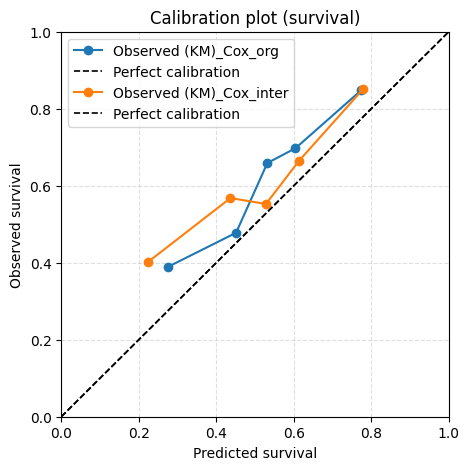

In [41]:
inter_feat_total = ['age','estrec','progrec', 'horTh']
interaction_list_total = [['tsize'], ['pnodes', 'age'],
 ['age', 'pnodes', 'estrec', 'horTh', 'tgrade', 'menostat'],['menostat','tsize', 'tgrade','pnodes', 'age']]
non_linear_list = []
# non_linear_list = ['age', 'tsize']
X_test_interact = X_test.copy()
X_train_interact = X_train.copy()
for i in range(len(inter_feat_total)):
  inter_feat = inter_feat_total[i]
  interaction_list = interaction_list_total[i]
  X_train_interact = interaction_analysis(X_train_interact,inter_feat, interaction_list, non_linear_list)
  X_test_interact = interaction_analysis(X_test_interact,inter_feat, interaction_list, non_linear_list)

cox_new_model = get_model('cox', 20)
cox_new_model.fit(X_train_interact, y_train)

evaluator.cal_metric_CI(cox_new_model, X_test_interact, y_test,'c-index')
calib = CalibrationPerform(t0=1500, kind='survival', random_state=0, save_folder='plots/', model_name=['Cox_org','Cox_inter'])
calib.calib_plot([org_model, cox_new_model], [[X_test, y_test], [X_test_interact,y_test]])
calib.calib_estimate(cox_new_model, X_test_interact, y_test)



c-index = 0.687 (95% CI 0.687-0.687), p = 1.0000
The intercept is 0.11196067848357467
The slope is 0.9448553586907265


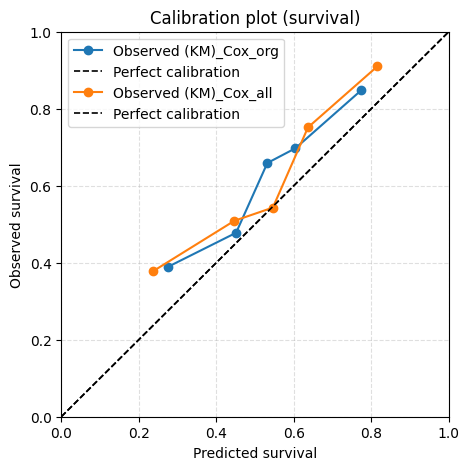

In [42]:
inter_feat_total = ['age','estrec','progrec', 'horTh']
interaction_list_total = [['tsize'], ['pnodes', 'age'],
 ['age', 'pnodes', 'estrec', 'horTh', 'tgrade', 'menostat'],['menostat','tsize', 'tgrade','pnodes', 'age']]
non_linear_list = ['age']
X_test_interact = X_test_nonlinear.copy()
X_train_interact = X_train_nonlinear.copy()
for i in range(len(inter_feat_total)):
  inter_feat = inter_feat_total[i]
  interaction_list = interaction_list_total[i]
  X_train_interact = interaction_analysis(X_train_interact,inter_feat, interaction_list, non_linear_list)
  X_test_interact = interaction_analysis(X_test_interact,inter_feat, interaction_list, non_linear_list)

cox_new_model = get_model('cox', 20)
cox_new_model.fit(X_train_interact, y_train)

evaluator.cal_metric_CI(cox_new_model, X_test_interact, y_test,'c-index')
calib = CalibrationPerform(t0=1500, kind='survival', random_state=0, save_folder='plots/', model_name=['Cox_org','Cox_all'])
calib.calib_plot([org_model, cox_new_model], [[X_test, y_test], [X_test_interact,y_test]])
calib.calib_estimate(cox_new_model, X_test_interact, y_test)

# ACT

In [ ]:
X, y = load_whas500()

cat_cols = ['afb', 'av3', 'chf', 'cvd', 'gender', 'miord', 'mitype', 'sho']
X[cat_cols] = OrdinalEncoder().fit_transform(X[cat_cols])

ex_model, (X_train, y_train), (X_test, y_test) = split_and_train(X, y, 'rf')
org_model, (X_train, y_train), (X_test, y_test) = split_and_train(X, y, 'cox')

con_cols = ['age', 'bmi', 'diasbp', 'hr', 'sysbp']
X[con_cols] = StandardScaler().fit_transform(X[con_cols])

In [ ]:
## Evaluate original model
evaluator = MetricEval(1000)
evaluator.cal_metric_CI(org_model, X_test, y_test,'c-index')
calib = CalibrationPerform(t0=320, kind='survival', random_state=0, save_folder='plots/act/', model_name=['Cox_org'])
calib.calib_plot([org_model], [[X_test, y_test]])
calib.calib_estimate(org_model, X_test, y_test)

## Evaluate rsf model
evaluator = MetricEval(1000)
evaluator.cal_metric_CI(ex_model, X_test, y_test,'c-index')
calib = CalibrationPerform(t0=320, kind='survival', random_state=0, save_folder='plots/act/', model_name=['rsf'])
calib.calib_plot([ex_model], [[X_test, y_test]])
calib.calib_estimate(ex_model, X_test, y_test)

In [ ]:
## Get feature interaction
org_X = X_train.copy()
org_y = y_train.copy()
df_shap_low, sel_data_low = get_explanations(ex_model, org_X, org_y, eps=0.1, risk_level='low')
make_plot(df_shap_low, sel_data_low, 'whas_org_shap_low_train', plot_type='violin', xlabel='SHAP value', figsize=(8, 6))
df_shap_high, sel_data_high = get_explanations(ex_model, org_X, org_y, eps=0.1, risk_level='high')
make_plot(df_shap_high, sel_data_high, 'whas_org_shap_high_train', plot_type='violin', xlabel='SHAP value', figsize=(8, 6))

In [ ]:
shapana = ShapleyAnalysis(0.05, 0.05, 0.05, random_state=20)
shapana.inclu_exclu_var(df_shap_low)
shapana.inclu_exclu_var(df_shap_high)
print('========non-linear=======')
shapana.non_linear_test(df_shap_low, sel_data_low)
shapana.non_linear_test(df_shap_high, sel_data_high)


In [ ]:
exclu_cols = ['av3']
exclu_train = X_train.copy()
exclu_test = X_test.copy()
X_train_exclu = exclusion_analysis(exclu_train, exclu_cols)
X_test_exclu = exclusion_analysis(exclu_test, exclu_cols)
cox_new_model = get_model('cox', 20)
cox_new_model.fit(X_train_exclu, y_train)

evaluator.cal_metric_CI(cox_new_model, X_test_exclu, y_test,'c-index')
calib = CalibrationPerform(t0=200, kind='survival', random_state=0, save_folder='plots/act/', model_name=['Cox_org','Cox_exclu'])
calib.calib_plot([org_model, cox_new_model], [[X_test, y_test], [X_test_exclu,y_test]])
calib.calib_estimate(cox_new_model, X_test_exclu, y_test)

In [ ]:
nonlinear_feature = ['sysbp']
nonlinear_train = X_train.copy()
nonlinear_test = X_test.copy()
X_train_nonlinear = nonlinear_analysis(nonlinear_train, nonlinear_feature, nonlinear_type='quadratic')
X_test_nonlinear = nonlinear_analysis(nonlinear_test, nonlinear_feature, nonlinear_type='quadratic')
cox_new_model = get_model('cox', 20)
cox_new_model.fit(X_train_nonlinear, y_train)

evaluator.cal_metric_CI(cox_new_model, X_test_nonlinear, y_test,'c-index')
calib = CalibrationPerform(t0=320, kind='survival', random_state=0, save_folder='plots/act/', model_name=['Cox_org','Cox_nonlinear'])
calib.calib_plot([org_model, cox_new_model], [[X_test, y_test], [X_test_nonlinear,y_test]])
calib.calib_estimate(cox_new_model, X_test_nonlinear, y_test)

In [ ]:
print('====== Low risk cohort ======')
sign_balance_test(df_shap_low)
print('====== High risk cohort ======')
sign_balance_test(df_shap_high)

In [ ]:
strata = {'bmi':0, 'cvd':0, 'diasbp':0, 'gender':1, 'sysbp':1, 'age':-0.5, 'mitype':0,'hr':-2}
for variable, thresh in strata.items():
  print(f'The stratified variable is {variable}')
  X_test_list, y_test_list =strata_generate(df_shap_low, variable, sel_data_low.reset_index(drop=True), y_test, thresh)
  shap_file = stratify_shap_analysis(ex_model, X_test_list, y_test_list, variable, risk_level=None)
  df1, df2 = shap_file[0], shap_file[1]
  shapana.wilcoxon_rank_sum_test(df1, df2)

In [ ]:
inter_feat_total = ['cvd','diasbp', 'gender', 'sysbp','age','mitype','hr']
interaction_list_total = [['diasbp', 'miord'],['bmi','sysbp'],['los','sysbp'],['mitype'],
                          ['bmi','gender','los','sysbp'],['miord'],['bmi']]
# non_linear_list = ['karnof', 'age']
non_linear_list = []
X_test_interact = X_test.copy()
X_train_interact = X_train.copy()
for i in range(len(inter_feat_total)):
  inter_feat = inter_feat_total[i]
  interaction_list = interaction_list_total[i]
  X_train_interact = interaction_analysis(X_train_interact,inter_feat, interaction_list, non_linear_list)
  X_test_interact = interaction_analysis(X_test_interact,inter_feat, interaction_list, non_linear_list)

cox_new_model = get_model('cox', 20)
cox_new_model.fit(X_train_interact, y_train)

evaluator.cal_metric_CI(cox_new_model, X_test_interact, y_test,'c-index')
calib = CalibrationPerform(t0=320, kind='survival', random_state=0, save_folder='plots/act/', model_name=['Cox_org','Cox_inter'])
calib.calib_plot([org_model, cox_new_model], [[X_test, y_test], [X_test_interact,y_test]])
calib.calib_estimate(cox_new_model, X_test_interact, y_test)


In [ ]:
X_train_final = X_train_exclu.copy()
X_test_final = X_test_exclu.copy()

X_train_final = nonlinear_analysis(X_train_final, nonlinear_feature, nonlinear_type='quadratic')
X_test_final = nonlinear_analysis(X_test_final, nonlinear_feature, nonlinear_type='quadratic')

inter_feat_total = ['cvd','diasbp', 'gender', 'sysbp','age','mitype','hr']
interaction_list_total = [['diasbp', 'miord'],['bmi','sysbp'],['los','sysbp'],['mitype'],
                          ['bmi','gender','los','sysbp'],['miord'],['bmi']]
non_linear_list = ['sysbp']

X_test_interact = X_test_final.copy()
X_train_interact = X_train_final.copy()
for i in range(len(inter_feat_total)):
  inter_feat = inter_feat_total[i]
  interaction_list = interaction_list_total[i]
  X_train_interact = interaction_analysis(X_train_interact,inter_feat, interaction_list, non_linear_list)
  X_test_interact = interaction_analysis(X_test_interact,inter_feat, interaction_list, non_linear_list)
cox_new_model = get_model('cox', 20)
cox_new_model.fit(X_train_interact, y_train)

evaluator.cal_metric_CI(cox_new_model, X_test_interact, y_test,'c-index')
calib = CalibrationPerform(t0=320, kind='survival', random_state=0, save_folder='plots/act/', model_name=['Cox_org','Cox_all'])
calib.calib_plot([org_model, cox_new_model], [[X_test, y_test], [X_test_interact,y_test]])
calib.calib_estimate(cox_new_model, X_test_interact, y_test)